# Home Dataset Creation

This notebook is used to create the home dataset, by composing different appliances and their respective power consumption. The dataset used is GREEND. The power consumption and metadata are read from the dataset using the [nilmtk](https://github.com/nilmtk) library.

## Setup

In [ ]:
%pip install git+https://github.com/nilmtk/nilmtk # Install from git because the conda package is out of date
%pip install git+https://github.com/nilmtk/nilm_metadata 

## Smart*

### Import Dataset

In [5]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

smart_star = DataSet('data/smart_star.h5')

## GREEND

In [1]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

greend = DataSet('data/greend.h5')

In [3]:
print_dict(greend.metadata)

MeterGroup(meters=
  ElecMeter(instance=1, building=3, dataset='GREEND', appliances=[Appliance(type='fridge', instance=1)], room=kitchen)
  ElecMeter(instance=2, building=3, dataset='GREEND', appliances=[Appliance(type='dish washer', instance=1)], room=kitchen)
  ElecMeter(instance=3, building=3, dataset='GREEND', appliances=[Appliance(type='microwave', instance=1)], room=kitchen)
  ElecMeter(instance=4, building=3, dataset='GREEND', appliances=[Appliance(type='kettle', instance=1)], room=kitchen)
  ElecMeter(instance=5, building=3, dataset='GREEND', appliances=[Appliance(type='washing machine', instance=1)], room=bathroom)
  ElecMeter(instance=6, building=3, dataset='GREEND', appliances=[Appliance(type='audio amplifier', instance=1)], room=lounge)
  ElecMeter(instance=7, building=3, dataset='GREEND', appliances=[Appliance(type='hair dryer', instance=1), Appliance(type='charger', instance=1)], room=bathroom)
  ElecMeter(instance=8, building=3, dataset='GREEND', appliances=[Appliance(ty

In [7]:
appliances = {
    1: ['radio', 'dish washer', 'fridge', 'coffee maker', 'television', 'kettle'],
    3: ['microwave', 'food processor'],
    5: ['vacuum cleaner'],
    6: ['electric oven'],
    7: ['toaster', 'washing machine']
}

def replace_with_average(group):
    group['power'] = group['power'].mean()
    return group.iloc[:1]

for building, appliance_list in appliances.items():
    print("> Building:", building)
    for appliance in appliance_list:
        print(f"  - Appliance: {appliance} ... ", end="")
        name_undercase = appliance.replace(' ', '_')

        df = next(greend.buildings[building].elec[appliance].load()).reset_index()
        df.columns = ["timestamp", "power"]
        df.drop(columns=["timestamp"], inplace=True)
        df = df.groupby(df.index // 120).apply(replace_with_average)
        df = df.reset_index(drop=True)
        df.dropna(inplace=True)

        df.to_csv(f"appliances/{name_undercase}.csv", index=False)
        print("OK")

> Building: 3
  - Appliance: food processor ... OK


## DEDDIAG

### Load Dataset

In [86]:
from nilmtk import DataSet

deddiag = DataSet('data/deddiag.h5')
building = 8
elec = deddiag.buildings[building].elec

In [5]:
from nilmtk.utils import print_dict

print_dict(deddiag.metadata)

### Extract Appliances

In [17]:
fridge = elec['fridge']
next(fridge.load())

physical_quantity,power
type,active
time,
2017-10-21 02:00:00+02:00,0.320297
2017-10-21 02:00:00+02:00,0.320297
2017-10-21 02:00:01+02:00,0.421655
2017-10-21 02:00:02+02:00,0.374965
2017-10-21 02:00:03+02:00,0.394815
...,...
2018-01-19 00:59:55+01:00,0.337772
2018-01-19 00:59:56+01:00,0.337772


In [26]:
next(fridge.when_on())

time
2017-10-21 02:00:00+02:00    False
2017-10-21 02:00:00+02:00    False
2017-10-21 02:00:01+02:00    False
2017-10-21 02:00:02+02:00    False
2017-10-21 02:00:03+02:00    False
                             ...  
2018-01-19 00:59:55+01:00    False
2018-01-19 00:59:56+01:00    False
2018-01-19 00:59:57+01:00    False
2018-01-19 00:59:58+01:00    False
2018-01-19 00:59:59+01:00    False
Name: (power, active), Length: 7890456, dtype: bool

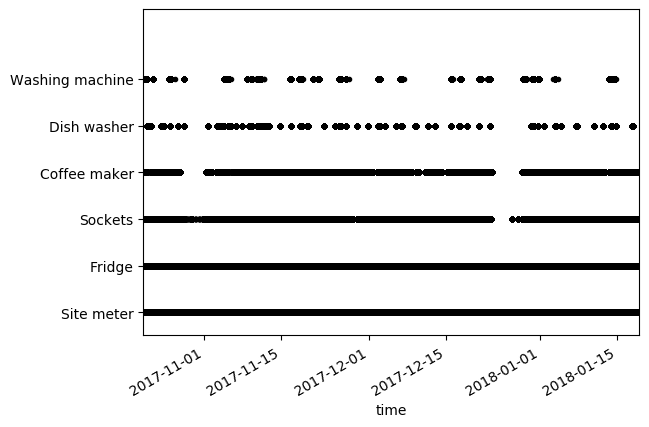

In [18]:
elec.plot_when_on()